## Experimental Differential Evolution Optimization of 4 Port MMI
### Rochester Institute of Technology
### David Starling & Matthew van Niekerk


Reference algorithm from these sources:

https://link.springer.com/article/10.1023%2FA%3A1008202821328

https://en.wikipedia.org/wiki/Differential_evolution

In [1]:
%matplotlib inline

import matplotlib as mpl #import of the plotting environment
import matplotlib.pyplot as plt # import of the plotting class
from matplotlib.gridspec import GridSpec

from ipywidgets import IntSlider, interact, ToggleButtons

import numpy as np # scientific number package
from numpy import random

import visa
from KeysightN7744A_Controller import KeysightN7744A_Controller # the optical power meter
import matplotlib.pyplot as plt # import of the plotting class
import numpy as np
import qontrol
import pickle
import threading
import AndoAQ4321 as ando
import time
import os
%matplotlib inline 
import progressbar

rm = visa.ResourceManager() # set the resource manager
# devices = rm.list_resources() # generates a list of resources available and serves as good debugging

q = qontrol.QXOutput(serial_port_name = 'COM11', repsonse_timeout = 0.1) # connect to qontrol with correct COM Port.
keysight_pm = KeysightN7744A_Controller('USB0::0x0957::0x3718::SG48101084::INSTR', verbose = False) # connect to the power meter
ando_laser = ando.AndoAQ4321(rm,address = 'GPIB1::24::INSTR')



RESOURCE CONNECTED
CONNECTED TO: Agilent Technologies, N7744A, SG48101084, 1.183

Connection Successful: ANDO-ELECTRIC/AQ4321D/00000000/HOST0D.02.11.00/SUB0D.02.14.00/LD0D.01.01.00

Locked: 0

Output: 1



In [4]:
n = 12 # number of inputs
maxV = 12 #voltage range, positive only

maxiter = 5000 #max number of iterations
condition = 500 #how many useless iterations in a row before exiting

CR = 0.1 #cross-over probability
F = .8 #differential weight

In [11]:
def optimize(maxiter,condition,CR,F,maxV,n):
    keysight_pm.set_units_watts()
    widgets = ['Differential Evolution (MAX TIME REMAINING): ', progressbar.Percentage(), progressbar.Bar(), progressbar.AdaptiveETA()]
    bar = progressbar.ProgressBar(widgets=widgets, max_value=maxiter).start()
    
    #initialize values
    x = [] #this is the test "best" test voltage so far
    values = [] #this is the ongoing power measurement
    for i in range(n):
        x.append(np.random.uniform(0,maxV)) #just a random starting point
    
    y = np.zeros(n) #this is the new voltage to test
    
    first_val = -10*np.log10(float(keysight_pm.measure_power())/0.001)
    values.append(first_val)
    
    j = 1 # counter for exit condition
    k = 1 # counter for maximum iterations
    while j < condition and k < maxiter: 
        
        #these three (nx1) vectors will be used to make the test voltage y
        A = []
        B = [] 
        C = []
        for m in range(n):
            A.append(np.random.uniform(0,maxV)) #uniform random variables 
            B.append(np.random.uniform(0,maxV))
            C.append(np.random.uniform(0,maxV))
    
        
        R = np.random.randint(1,n+1) #this one of the n elements definitely changes
        for i in range(n):
            #Change, or don't change each element of the test voltage            
            r = np.random.uniform(0,1)
            if r < CR or i + 1 == R: 
                y[i] = A[i] + F*(B[i] - C[i])
                if y[i] < 0 or y[i] > maxV: #just make sure the voltage isn't out of range
                    y[i] = x[i] #this was my choice; I also tried setting y[i] to max or 0 but this was better
            else:
                y[i] = x[i] #don't change this element alone
        
        #Here's where you apply voltages y and measure power f(y)
        for chan in range(0,len(y)):
            q.v[chan] = float(y[chan])
        time.sleep(0.5)
        this_value = -10*np.log10(float(keysight_pm.measure_power())/0.001)
        #Check if new voltage vector y is better than old voltage vector x
        #replace f(y,a,w) with new power measurement, and f(x,a,w) with old best power measurement (basically values[-1])
        q.v[:] = 0
        #if f(y,a,w) < f(x,a,w):
        if this_value < values[-1]:
            x = np.array(y) 
            j = 1 #reset counter to 1
        #elif f(y,a,w) == f(x,a,w):
        elif this_value == values[-1]:
            x = np.array(y) 
            j = j + 1 #increase the condition counter
        #elif f(y,a,w) > f(x,a,w):
        elif this_value > values[-1]:
            this_value = values[-1]
            j = j + 1 #increase the condition counter
        
        values.append(this_value)
        
        k = k + 1 #increase the maximum iteration counter
        bar.update(k)
        
    bar.finish()
    return x, values

In [12]:
CRs = np.linspace(0,1,7)
Fs = np.linspace(0,2,7)

ando_laser.outputON()

bestCR = 0
bestF = 0
bestvalue = 1e6
for CR in CRs:
    for F in Fs:
        x, values = optimize(100,25,CR,F,maxV,n)
        if values[-1] < bestvalue:
            bestvalue = values[-1]
            bestCR = CR
            bestF = F
            bestcondition = condition

print(str(bestvalue) + ': F = ' + str(bestF) + ', CR = ' + str(bestCR))

Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:01:58
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:01:37
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:01:36
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:02:38
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:01:21
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:02:27
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:02:06
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:00:51
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:01:39
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:01:16
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:00:48
Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:01:07
Differential Evolution (MAX TIME REMAINI

34.34334788614564: F = 1.0, CR = 0.3333333333333333


In [13]:
x, values = optimize(maxiter,condition,bestCR,bestF,maxV,n)
print(str(values[-1]) + ' with ' + str(len(values)) + ' iterations')

Differential Evolution (MAX TIME REMAINING): 100%|##############|Time:  0:32:28


34.43622469278796 with 1218 iterations


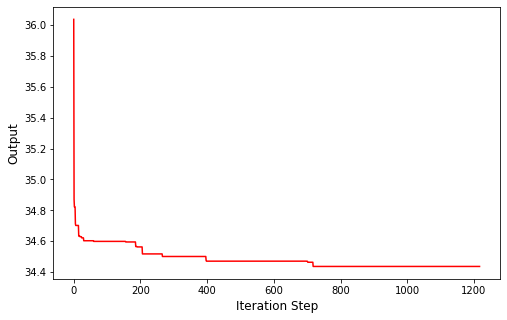

In [14]:
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot()
ax.set_xlabel('Iteration Step', fontsize=12)
ax.set_ylabel('Output', fontsize=12)

ax.plot(values,'r')

In [15]:
# Save the data for later inspection.

def save_data(obj, filename ):
    with open(filename +'.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_data(name ):
    with open(name +'.pkl', 'rb') as f:
        return pickle.load(f)
    
config_name = 'Port1-Port3-2x6pins_'
filename_base = os.getcwd() + '/data/' + config_name

In [16]:
data = {}
data['final_voltage_config'] = x
data['value_evolution'] = values
filename_base = os.getcwd() + '/data/' + 'differential_evolution_port1_maximize_5000'
save_data(data,filename_base)

In [17]:
ando_laser.outputOFF()
q.v[:] = 0